# Gorilla Data Engineer Assessment

## 0. Preparation

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
df_meter = pd.read_excel('gorilla_test_data.xlsx', sheet_name='meter_list')
df_forecast = pd.read_excel('gorilla_test_data.xlsx', sheet_name='forecast_table')
df_rate = pd.read_excel('gorilla_test_data.xlsx', sheet_name='rate_table')

## 1. Calculating total transportation distribution charges

### Getting start and end dates for each row

In [3]:
def add_end_dates(df_rates):
    # Rename the date column to indicate this is the start date
    df_rates = df_rates.rename(columns={'date': 'start_date'})

    # Sort the dataframe to make sure the dates are in order
    df = df_rates.sort_values(by='start_date')

    # Get a list of unique starting dates to determine the next starting date
    df_unique = df[['start_date']].drop_duplicates()

    # Add an end date that is one day before the next start date
    df_unique['end_date'] = df_unique['start_date'].shift(-1) - pd.Timedelta(days=1)

    # Add the end date to the original dataframe
    df_rates = pd.merge(df, df_unique, on='start_date', how='left')
    
    return df_rates

### Filtering the rates for each meter

In [4]:
def filter_rates(df_meters, df_rates):
    # First we merge the dataframes to only consider the correct exit zone for each meter
    df_rates_filtered = pd.merge(df_meters, df_rates, on='exit_zone')
    # The we remove all rows where the aq_kwh is not between the min and max
    df_rates_filtered = df_rates_filtered[(df_rates_filtered['aq_kwh'] >= df_rates_filtered['aq_min_kwh']) 
                                        & ((df_rates_filtered['aq_kwh'] < df_rates_filtered['aq_max_kwh']) 
                                           | (df_rates_filtered['aq_max_kwh'].isnull()))]
    return df_rates_filtered

### Getting the total consumption per meter

In [5]:
def get_total_consumption(df_rates_filtered, df_forecasts):
    # Merge the rate and the forecast dataframes
    df_merged = pd.merge(df_rates_filtered, df_forecasts, on='meter_id', how='inner')

    # Multiply the forecasted amount by the rate to get the predicted charge in pence
    df_merged['predicted_cost'] = df_merged['kwh'] * df_merged['rate_p_per_kwh']

    # Get the total for each meter by grouping them and getting the sum of the predicted costs column
    df_total_predicted_cost = df_merged.groupby('meter_id')[['kwh', 'predicted_cost']].sum().reset_index()
    
    # Divide the predicted cost by 100 to get the cost in pounds & round it to two decimals
    df_total_predicted_cost['predicted_cost'] = (df_total_predicted_cost['predicted_cost']/100).round(2)
    
    # Cleaning up the solution
    df_solution = df_total_predicted_cost.rename(columns={'meter_id': 'Meter ID', 'kwh': 'Total Estimated Consumption (kWh)', 
                                                          'predicted_cost': 'Total Cost (£)'})
    
    return df_solution

### Showing the results of the first exercise

In [6]:
# Rename the column so they match the assignment
df_rates = add_end_dates(df_rate.copy())
df_rates_filtered = filter_rates(df_meter.copy(), df_rates)
df_solution = get_total_consumption(df_rates_filtered, df_forecast.copy())
df_solution.head()

,Meter ID,Total Estimated Consumption (kWh),Total Cost (£)
0,14676236,289780.0,1348.64
1,34509937,783240.0,3770.28
2,50264822,2656670.0,10168.14
3,88357331,4843990.0,19703.90


## 2. Random meters generation

In [7]:
# The rates should be passed to this function so that it can extract all possible exit zones
# n is the amount of ransom meters to generate, with a default of 10
# The meter value is always 8 numbers long and the aq_kwh cannot be over one million
def generate_random_meters(df_rate, n=10):
    # Get the possible exit zones
    exit_zones = df_rate['exit_zone'].unique().tolist()
    columns = ['meter_id', 'aq_kwh', 'exit_zone']
    # Create an empty dataframe
    df = pd.DataFrame(columns=columns)
    for i in range(n):
        # Generate the random values
        random_meter = np.random.randint(10000000, 100000000, dtype=np.int64)
        random_kwh = np.random.randint(0, high= 1000001, dtype=np.int64)
        random_zone = exit_zones[np.random.randint(0, len(exit_zones), dtype=np.int64)]
        # Create a new row with the random values
        new_row = pd.DataFrame([[random_meter, random_kwh, random_zone]], columns=columns)
        # Add the new row to the dataframe
        df = pd.concat([df, new_row])
    return df

## 3. Random consumption data

In [8]:
# This function generates a random quantity between 1 and 100.000 for each meter on each day of the provided period
def generate_random_consumption(meters, start_date, duration):
    # Get all the dates in the period
    date_range = pd.date_range(start=start_date, periods=duration)
    # Generate all possible combinations of meters and dates
    meter_col, date_col = np.meshgrid(meters, date_range)
    # Generate a random value between 1 and 100.000 for each combination
    value_col = np.random.randint(1, 100001, size=meter_col.shape)
    # Return the data
    return pd.DataFrame({'meter_id': meter_col.ravel(), 'date': date_col.ravel(), 'kwh': value_col.ravel()})

## 4. Benchmarking the transportion costs function

### First we create a function to make the benchmarking easier

In [9]:
# calculate the total transportation costs for n_meters ransom emters and n_periods days
def random_transportion_costs(n_meters, n_periods):
    df_random_meters = generate_random_meters(df_rate, n_meters)
    df_random_consumption = generate_random_consumption(df_random_meters['meter_id'].to_list(), '2020-04-01', n_periods)
    df_rates = add_end_dates(df_rate.copy())
    df_rates_filtered = filter_rates(df_random_meters, df_rates)
    df_solution = get_total_consumption(df_rates_filtered, df_random_consumption)
    return df_solution

### Execution time in function of number of meters

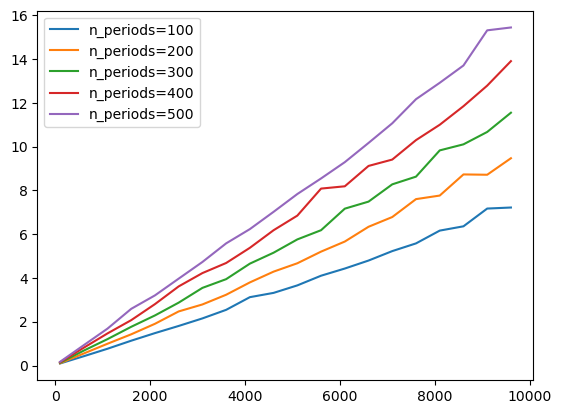

In [162]:
x = range(100,10100,500)
for i in range(100, 600, 100):
    times = []
    for j in x:
        start_time = time.time()
        df_solution = random_transportion_costs(j, i)
        end_time = time.time()
        times.append(end_time - start_time)
    plt.plot(x, times, label='n_periods='+str(i))
plt.legend()
plt.show()

### Execution time in function of number of periods

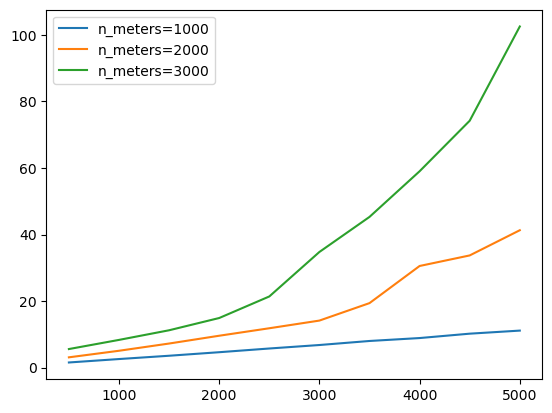

In [11]:
x = range(500,5100,500)
for i in range(1000, 4000, 1000):
    times = []
    for j in x:
        start_time = time.time()
        df_solution = random_transportion_costs(i, j)
        end_time = time.time()
        times.append(end_time - start_time)
    plt.plot(x, times, label='n_meters='+str(i))
plt.legend()
plt.show()

## 5. Observations
Increasing the number of meters seems increases the time linearly, which means that the complexity of this function is O(n) with n the number of meters. 

Increasing the number of periods increases the time exponentially. This is the weakest point if the function and should be improved further. It should also be able to be executed linearly for optimal scalability.

One improvement to speed up the calculation would be to already add an end date to the rate dataset. This would cut out the first step in the calculation, which would decrease the time it takes to do the calculation.

Because the calculations are already vectorized there is not much room for improvement. The main way of improving code like this would be to use a different set of operations, that are more efficient, to achieve the same results.

Another possible way to speed it up is to code the operations in C, since this language is more efficient than python it will also speed up the calculations. We could do this in python by using Cython to write C extensions in python. Numba is also a way to speed up python code. But then the operations should be executed on numpy arrays and not on pandas dataframes.